![Logo of the project](../docs/img/udacity_logo.svg)

# Machine Learning Engineer Nanodegree
## Capstone Project
## Landmark Recognition
**Fady Morris Milad Ebeid**  
_December 5, 2019_

## I. Definition

### Project Overview

Computer vision algorithms include methods for acquiring, processing, analyzing and understanding digital images, and extraction of data from the real world. It is an interdisciplinary field that deals with how can computers gain a high-level understanding of digital images. It aims to mimic human vision.  
Convolutional neural networks are now capable of outperforming humans on some computer vision tasks,
such as classifying images.  
In this project, I provide a solution to the Landmark Recognition Problem. Given an input photo of a place anywhere around the world, the computer can recognize and label the landmark in which this image was taken.  
The dataset I used for this project is Kaggle Google Landmark Recognition 2019 dataset and can be
downloaded from Common Visual Data Foundation 1 Google Landmarks Dataset v2.  

#### Importing Libraries :

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames
import matplotlib.pyplot as plt

# Pretty display for notebooks
%matplotlib inline

In [2]:
import sys, os
from os import path
import csv
import pickle #object binary serialization

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #suppress tensorflow warnings

In [4]:
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras.utils import plot_model
from keras import applications, optimizers
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

Using TensorFlow backend.


#### Connecting to google drive and copying dataset to colab virtual machine :

In [0]:
from google.colab import drive
drive.mount('/gdrive')

In [0]:
cd /

/


In [0]:
%%shell
cp -v /gdrive/My\ Drive/shared/Udacity_MLND_capstone_dataset/data.tar.gz /
tar xvzf data.tar.gz
mkdir models
mkdir -p docs/figures
mkdir -p docs/stats

#### Data paths definitions :

In [6]:
# Data paths definitions :
data_dir = "../data"
input_csv_dir = path.join(data_dir,"input_csv") #csv files that were dowlnoaded from kagggle
train_dir = path.join(data_dir, "train") ##Training images directory
validation_dir = path.join(data_dir, "validation") ##Validation images directory
test_dir = path.join(data_dir, "test") ##Validation images directory
test_images_dir = path.join(data_dir, "test_images") #test images directory (unlabeled images used for prediction)

models_dir = "../models"
docs_dir = "../docs"
stats_dir = path.join(docs_dir, "stats") #Output csv statistics directory
figures_dir = path.join(docs_dir, "figures") #Output directory for saving figures

### Problem Statement

Did you ever go through your vacation photos and ask yourself: What is the name of this temple I visited in China? Who created this monument I saw in France? Landmark recognition can help! This technology can predict landmark labels directly from image pixels, to help people better understand and organize their photo collections.  
This problem was inspired by Google Landmark Recognition 2019 Challenge on Kaggle.  
Landmark recognition is a little different from other classification problems. It contains a much larger number of classes (there are a total of 15K classes in this challenge), and the number of training examples per class may not be very large. Landmark recognition is challenging in its way.  
This problem is a multi-class classification problem. In this problem, I built a classifier that can be trained using the given dataset and can be used to predict the landmark class from a given input image.  
I have chosen to use convolutional neural networks and transfer learning techniques as classifiers. CNNs yield better results than traditional computer vision algorithms. I trained a basic convolutional neural network, then used pre-trained VGG16 and Xception models in transfer learning to solve the Google Landmark Recognition 2019 Problem.

### Metrics

####  Global Average Precision Metric

> Source : [Google Landmark Recognition 2019 - Evaluation](https://www.kaggle.com/c/landmark-recognition-2019/overview/evaluation)

This metric is also known as micro Average Precision (microAP), as per [F. Perronnin, Y. Liu, and J.-M. Renders, "A Family of Contextual Measures of Similarity between Distributions with Application to Image Retrieval," Proc. CVPR'09](https://ieeexplore.ieee.org/document/5206505)

$$GAP = \frac{1}{M}\sum_{i=1}^N P(i) rel(i)$$

**where:**

* $N$ is the total number of predictions returned by the system, across all queries
* $M$ is the total number of queries with at least one landmark from the training set visible in it (note that some queries may not depict landmarks)
* $rel(i)$ denotes the relevance of prediciton $i$
$$
rel(i)=
\begin{cases}
1, \qquad \text{if the $i$-th prediction is correct}\\
0, \qquad \text{otherwise}
\end{cases}
$$
* $P(i)$ is the precision at rank $i$, $$\displaystyle P(i) = \frac{1}{i}\sum_{j=1}^i rel(j)$$

> Script Source : [Kaggle - David Thaler - Gap Metric](https://www.kaggle.com/davidthaler/gap-metric)

In [0]:
# Script Source : [Kaggle - David Thaler - Gap Metric](https://www.kaggle.com/davidthaler/gap-metric)
def GAP_vector(pred, conf, true, return_x=False):
    '''
    Compute Global Average Precision (aka micro AP), the metric for the
    Google Landmark Recognition competition. 
    This function takes predictions, labels and confidence scores as vectors.
    In both predictions and ground-truth, use None/np.nan for "no label".

    Args:
        pred: vector of integer-coded predictions
        conf: vector of probability or confidence scores for pred
        true: vector of integer-coded labels for ground truth
        return_x: also return the data frame used in the calculation

    Returns:
        GAP score
    '''
    x = pd.DataFrame({'pred': pred, 'conf': conf, 'true': true})
    x.sort_values('conf', ascending=False, inplace=True, na_position='last')
    x['correct'] = (x.true == x.pred).astype(int)
    x['prec_k'] = x.correct.cumsum() / (np.arange(len(x)) + 1)
    x['term'] = x.prec_k * x.correct
    gap = x.term.sum() / x.true.count()
    if return_x:
        return gap, x
    else:
        return gap

Here We define a class that records performance metrics to csv file and initialize an instance of it:

In [0]:
class StatsCSV:
    def __init__(self, csv_file):
        self.csv_file = csv_file
        with open(self.csv_file, 'w', newline='') as csvfile:
            header_writer = csv.writer(csvfile)
            header_writer.writerow(['Model', 'Test Loss', 'Test Accuracy', 'Test GAP'])
            
    def add_stats(self,model_name, loss, accuracy, GAP):
        with open(self.csv_file, 'a', newline='') as csvfile:
            stats_writer = csv.writer(csvfile)
            stats_writer.writerow([model_name, round(loss,4), round(accuracy * 100, 2), round(GAP * 100, 2)])

In [0]:
stats_csv = StatsCSV(path.join(stats_dir, "stats.csv"))

## II. Analysis

### Data Exploration

#### Variables and Class definitions :

In [0]:
class IndexCSV:
    def __init__(self, name, index_csv_dir, index_csv_file):
        try:
            self.index_data = pd.read_csv(path.join(index_csv_dir, index_csv_file), usecols=['id', 'category'])
            print("File has {} samples with {} features each.".format(*self.index_data.shape))
        except:
            print("File could not be loaded. Is the dataset missing?")
        self.name = name
        self.fig = None
        self.ax = None
        self.freqs = None

    def get_freqs(self):
        self.freqs = self.index_data['category'].value_counts().to_frame()
        self.freqs.columns = ['images_count']
        return self.freqs
    def get_plot(self):
        #self.fig, self.ax = plt.subplots()
        self.ax = self.index_data['category'].value_counts().plot.barh(title=self.name)
        self.ax.set(xlabel='Images Count', ylabel='Landmark (Class) Name')
        self.ax.grid(True)
        return self.ax

Load index csv files :

In [10]:
index_train_csv = IndexCSV("Training Data", data_dir, "index_train.csv")
index_validation_csv = IndexCSV("Validation Data", data_dir, "index_validation.csv")
index_test_csv = IndexCSV("Test Data", data_dir, "index_test.csv")

File has 7083 samples with 2 features each.
File has 1518 samples with 2 features each.
File has 1518 samples with 2 features each.


#### Selected Landmarks (Categories)

In [11]:
landmarks_list = index_validation_csv.index_data.groupby('category').nunique().index.to_list()
landmarks_df = pd.DataFrame(landmarks_list , index=np.arange(1, len(landmarks_list) + 1), columns = ['Landmarks'])
display(landmarks_df)

Landmarks
1              Burrator
2              Dead_Sea
3      Feroz_Shah_Kotla
4    Golden_Gate_Bridge
5   Hayravank_monastery
6     Kasteel_Amerongen
7                 Kazan
8                Masada
9          Matka_Canyon
10       Mount_Arapiles

In [0]:
landmarks_df.to_csv(os.path.join(stats_dir, "selected_landmarks.csv"), index=True) #Save to CSV

#### Training Data Frequencies and Count :

In [0]:
train_freqs = index_train_csv.get_freqs()
display(train_freqs)

images_count
Masada                        739
Dead_Sea                      734
Hayravank_monastery           730
Golden_Gate_Bridge            726
Mount_Arapiles                719
Matka_Canyon                  712
Feroz_Shah_Kotla              685
Burrator                      683
Kazan                         682
Kasteel_Amerongen             673

In [0]:
train_freqs.to_csv(os.path.join(stats_dir, "train_freqs.csv"), index=True)

#### Validation Data Frequencies and Count :

In [0]:
validation_freqs = index_validation_csv.get_freqs()
display(validation_freqs)

images_count
Masada                        159
Hayravank_monastery           157
Dead_Sea                      157
Golden_Gate_Bridge            155
Mount_Arapiles                154
Matka_Canyon                  153
Burrator                      147
Feroz_Shah_Kotla              146
Kazan                         146
Kasteel_Amerongen             144

In [0]:
validation_freqs.to_csv(os.path.join(stats_dir, "validation_freqs.csv"), index=True)

#### Test Data Frequencies and Count :

In [0]:
test_freqs = index_test_csv.get_freqs()
display(test_freqs)

images_count
Masada                        158
Hayravank_monastery           157
Dead_Sea                      157
Golden_Gate_Bridge            156
Mount_Arapiles                154
Matka_Canyon                  152
Feroz_Shah_Kotla              147
Kazan                         147
Burrator                      146
Kasteel_Amerongen             144

In [0]:
test_freqs.to_csv(os.path.join(stats_dir, "test_freqs.csv"), index=True)

### Exploratory Visualization

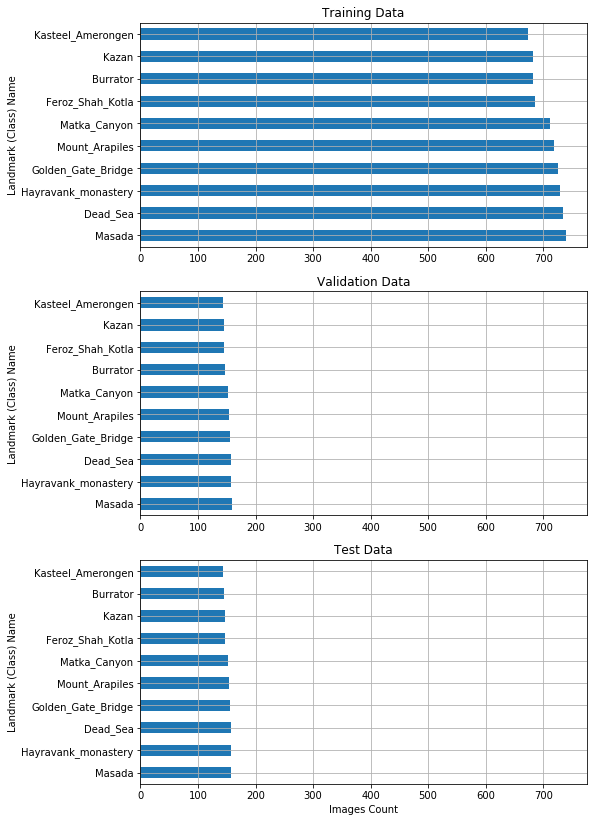

In [0]:
plt.figure(figsize=(8, 14))

plt.subplot(311)
index_train_ax = index_train_csv.get_plot()
plt.subplot(312, sharex=index_train_ax)
index_validation_ax = index_validation_csv.get_plot()
plt.subplot(313, sharex=index_train_ax)
index_test_ax = index_test_csv.get_plot()

index_train_ax.xaxis.set_tick_params(which='both', labelleft=True) # Get ticklabels back on shared axis
index_validation_ax.xaxis.set_tick_params(which='both', labelleft=True) # Get ticklabels back on shared axis

plt.savefig(path.join(figures_dir, "dataset_hbar_plot.pdf"), bbox_inches = 'tight')
plt.show()

### Algorithms and Techniques

### Benchmark

The code snippet below is our benchmark model, a simple stack of 3 convolution layers with a ReLU activation and followed by max-pooling layers. This is very similar to the architectures that Yann LeCun advocated in the 1990s for image classification (with the exception of ReLU). [citation - Handwritten Zip Code Recognition with Multilayer Networks](http://ieeexplore.ieee.org/document/119325/)

#### Benchmark Data Processing

In [0]:
class BenchmarkDataProcessor:
    def __init__(self, input_shape, batch_size, train_dir, vaidation_dir, test_dir):
        self.train_datagen = ImageDataGenerator(
                        rescale = 1.0/255, #rescale pixel values from [0,255] to [0,1]
                        rotation_range=40,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True,
                        fill_mode='nearest')
        self.test_datagen = ImageDataGenerator(rescale=1.0/255)

        self.input_shape = input_shape
        self.batch_size = batch_size

        self.init_train_generator(train_dir)
        self.init_validation_generator(validation_dir)
        self.init_test_generator(test_dir)

    def __init_generator(self, datagen, images_dir):
        return datagen.flow_from_directory(
                        directory=images_dir ,  # this is the target directory
                        target_size=self.input_shape[:2],  # all images will be resized to input shape 224x224
                        color_mode="rgb",
                        batch_size=self.batch_size,
                        class_mode='categorical',
                        shuffle=False)  
    def init_train_generator(self, train_dir):
        self.train_generator = self.__init_generator(self.train_datagen, train_dir)

    def init_validation_generator(self, validation_dir):
        self.validation_generator = self.__init_generator(self.test_datagen, validation_dir)
    def init_test_generator(self, test_dir):
        self.test_generator = self.__init_generator(self.test_datagen, test_dir)    

In [7]:
input_shape=(224, 224, 3)
batch_size = 16

In [0]:
benchmark_data_processor = BenchmarkDataProcessor(
    input_shape, 
    batch_size, 
    train_dir, 
    validation_dir,
    test_dir)

Found 7082 images belonging to 10 classes.
Found 1516 images belonging to 10 classes.
Found 1518 images belonging to 10 classes.


#### Example data augmentation :

In [0]:
img = load_img(path.join(train_dir, "Kazan/3e222ad7d1469deb.jpg"))
img_array = img_to_array(img)

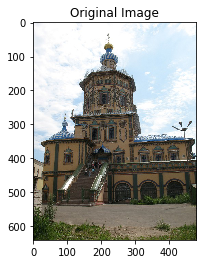

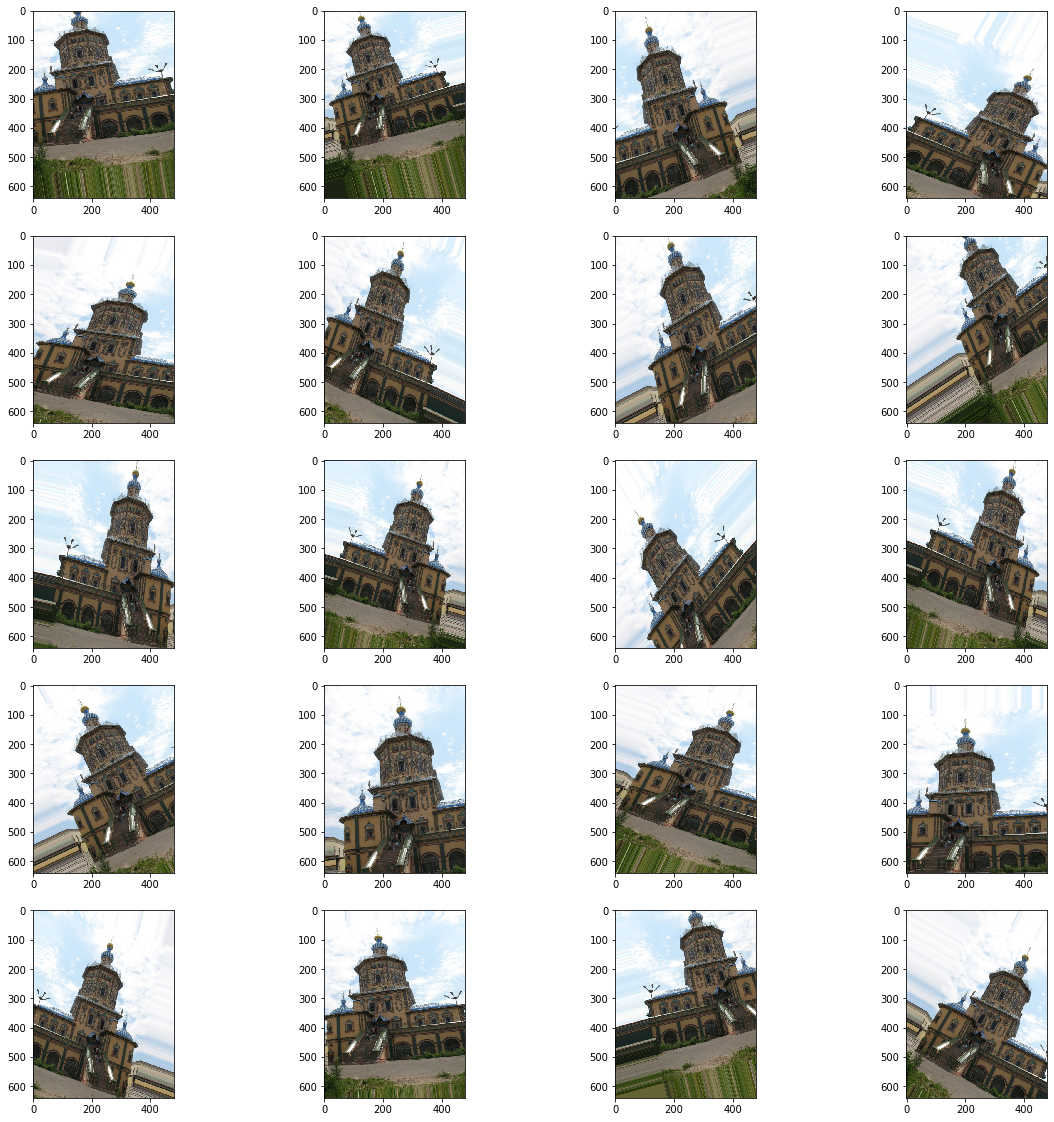

In [0]:
plt.imshow(img_array/255)
plt.title("Original Image")
plt.savefig(path.join(figures_dir, "augmented_image_original.pdf"), bbox_inches = 'tight')
plt.show()

#----------------------------

columns = 4
rows = 5
fig = plt.figure(figsize=(20,20))

for i, batch in enumerate(benchmark_data_processor.train_datagen.flow(img_array.reshape((1,) + img_array.shape), batch_size=16)):
    if i > rows * columns - 1:
      break
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(batch[0])

plt.savefig(path.join(figures_dir, "augmented_image_transformations.pdf"), bbox_inches = 'tight')
plt.show()

#### Benchmark Model Architecture

In [10]:
# My benchmark model - a simple CNN
benchmark_model = Sequential()

benchmark_model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
benchmark_model.add(MaxPooling2D(pool_size=(2, 2)))
benchmark_model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
benchmark_model.add(MaxPooling2D(pool_size=(2, 2)))
benchmark_model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
benchmark_model.add(MaxPooling2D(pool_size=(2, 2)))
benchmark_model.add(GlobalAveragePooling2D())
#benchmark_model.add(Flatten())
benchmark_model.add(Dense(64, activation='relu'))
benchmark_model.add(Dropout(0.5))
benchmark_model.add(Dense(10, activation='softmax'))


benchmark_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 64)                0         
__________

In [ ]:
benchmark_model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [9]:
# Save Model Architecture to file
plot_model(benchmark_model,
           to_file=path.join(figures_dir, "benchmark_model_architecture.pdf"),
           show_shapes=True,
           show_layer_names=False
          )

#### Benchmark Model Training

In [12]:
benchmark_weights_file = path.join(models_dir, "benchmark-model_weights.hdf5")
benchmark_history_file = path.join(models_dir, "benchmark-model_history.pickle")

In [0]:
#Checkpointer to save model best weights
benchmark_checkpointer = ModelCheckpoint(filepath = benchmark_weights_file,
                                         monitor='val_acc',
                                         verbose=1,
                                         save_best_only=True)

In [0]:
#Early Stopping
early_stopping = EarlyStopping(monitor='val_acc',
                               verbose=1,
                               patience=10)

In [0]:
epochs = 50 
steps_per_epoch = benchmark_data_processor.train_generator.samples // benchmark_data_processor.batch_size 
validation_steps = benchmark_data_processor.validation_generator.samples // benchmark_data_processor.batch_size

In [0]:
#epochs = 5
#steps_per_epoch = 15
#validation_steps = 4

In [0]:
benchmark_model_history = benchmark_model.fit_generator(
        benchmark_data_processor.train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        callbacks = [benchmark_checkpointer, early_stopping],
        validation_data=benchmark_data_processor.validation_generator,
        validation_steps=validation_steps,
        verbose=1)

Epoch 1/50
442/442 [==============================] - 49s 111ms/step - loss: 2.3055 - acc: 0.1015 - val_loss: 2.2559 - val_acc: 0.2207

Epoch 00001: val_acc improved from -inf to 0.22074, saving model to ../models/benchmark-model_weights.hdf5
Epoch 2/50
442/442 [==============================] - 56s 127ms/step - loss: 2.2095 - acc: 0.1903 - val_loss: 2.0548 - val_acc: 0.3040

Epoch 00002: val_acc improved from 0.22074 to 0.30400, saving model to ../models/benchmark-model_weights.hdf5
Epoch 3/50
442/442 [==============================] - 55s 124ms/step - loss: 2.0988 - acc: 0.2503 - val_loss: 1.9875 - val_acc: 0.2933

Epoch 00003: val_acc did not improve from 0.30400
Epoch 4/50
442/442 [==============================] - 51s 115ms/step - loss: 2.0170 - acc: 0.2895 - val_loss: 2.0772 - val_acc: 0.2447

Epoch 00004: val_acc did not improve from 0.30400
Epoch 5/50
442/442 [==============================] - 49s 111ms/step - loss: 1.9388 - acc: 0.3175 - val_loss: 1.8064 - val_acc: 0.4060

Epo

In [0]:
# Save Model History
with open(benchmark_history_file, 'wb') as pickle_file:
    pickle.dump(benchmark_model_history, pickle_file)

In [14]:
# Load Model History
with open(benchmark_history_file, 'rb') as pickle_file:
    benchmark_model_history = pickle.load(pickle_file)

In [0]:
# Loading Best Weights
benchmark_model.load_weights(benchmark_weights_file)

#### Benchmark Model Visualization (Learning Curves) :

In [15]:
def plot_learning_curves(model_history, model_name, plot_filename):
  fig, ax = plt.subplots(2, 1)
  fig.set_size_inches(8, 12)
  #fig.suptitle(model_name + ' Performance Metrics')
  ax[0].plot(model_history.history['acc'])
  ax[0].plot(model_history.history['val_acc'])
  ax[0].set_title(model_name + ' Performance Metrics\n' + 'Accuracy')
  ax[0].legend(['Training', 'Validation'], loc='upper left')
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Accuracy')
  ax[0].grid(True)
  ax[1].plot(model_history.history['loss'])
  ax[1].plot(model_history.history['val_loss'])
  ax[1].set_title('Loss')
  ax[1].legend(['Training', 'Validation'], loc='upper right')
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Loss')
  ax[1].grid(True)
  plt.savefig(plot_filename, bbox_inches = 'tight')
  plt.show()

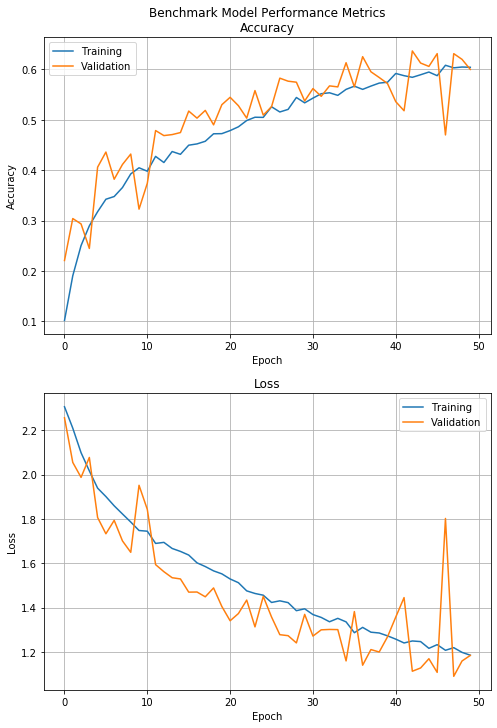

In [16]:
plot_learning_curves(benchmark_model_history, 'Benchmark Model', path.join(figures_dir, "benchmark_model_metrics.pdf"))

#### Benchmark Model Testing :

Accuracy :

In [0]:
[benchmark_test_loss, benchmark_test_accuracy] = benchmark_model.evaluate_generator(benchmark_data_processor.test_generator, benchmark_data_processor.test_generator.samples, workers=2, use_multiprocessing=True, verbose=1)
print(benchmark_model.metrics_names)
print([benchmark_test_loss, benchmark_test_accuracy])

1518/1518 [==============================] - 152s 100ms/step
['loss', 'acc']
[1.1270842477193972, 0.6429219225909746]


GAP :

In [0]:
def get_GAP(model, test_generator):
  test_generator.reset()
  samples_count = test_generator.samples
  images = np.empty((0,) + input_shape)
  max_batch_index = len(test_generator)
  i = 0
  for batch in test_generator:
      images = np.append(images, batch[0], axis=0) #image data
  #   print(batch[1][i]) #image labels
      i += 1
      if i > max_batch_index - 1:
          break  

  probabilities = model.predict(images)
  predicted_classes = model.predict_classes(images)
  confidence_scores = probabilities[(np.arange(samples_count), predicted_classes)]
  true_labels = test_generator.labels
  return GAP_vector(predicted_classes, confidence_scores, true_labels)

In [0]:
benchmark_test_GAP = get_GAP(benchmark_model, benchmark_data_processor.test_generator)
print(benchmark_test_GAP)

0.558556285543901


Saving results :

In [0]:
stats_csv.add_stats("Benchmark Model", benchmark_test_loss, benchmark_test_accuracy, benchmark_test_GAP)

## III. Methodology

<a id='data_preprocessing'></a>
### Data Preprocessing

In [19]:
class DataProcessor:
    def __init__(self, input_shape, batch_size, train_dir, validation_dir, test_dir):
        self.train_datagen = ImageDataGenerator(rescale = 1.0/255) #rescale pixel values from [0,255] to [0,1]
        self.test_datagen = ImageDataGenerator(rescale=1.0/255)

        self.input_shape = input_shape
        self.batch_size = batch_size

        self.init_train_generator(train_dir)
        self.init_validation_generator(validation_dir)
        self.init_test_generator(test_dir)

    def __init_generator(self, datagen, images_dir):
        return datagen.flow_from_directory(
                        directory=images_dir ,  # this is the target directory
                        target_size=self.input_shape[:2],  # all images will be resized to input shape 224x224
                        batch_size=self.batch_size,
                        class_mode=None,
                        shuffle=False)  
    def init_train_generator(self, train_dir):
        self.train_generator = self.__init_generator(self.train_datagen, train_dir)

    def init_validation_generator(self, validation_dir):
        self.validation_generator = self.__init_generator(self.test_datagen, validation_dir)
    def init_test_generator(self, test_dir):
        self.test_generator = self.__init_generator(self.test_datagen, test_dir)    

In [18]:
input_shape=(224, 224, 3)
batch_size = 1

In [20]:
data_processor = DataProcessor(
    input_shape, 
    batch_size, 
    train_dir, 
    validation_dir,
    test_dir)

Found 7082 images belonging to 10 classes.
Found 1516 images belonging to 10 classes.
Found 1518 images belonging to 10 classes.


### Implementation

In [27]:
class PretrainedModel:
    def __init__(self, model_name, pretrained_model, data_processor, save_path ):
        self.model_name = model_name
        self.pretrained_model = pretrained_model
        self.data_processor = data_processor
        self.save_path = save_path

    def get_file_path(self, file_name):
      return path.join(self.save_path, self.model_name + '_' + file_name)
        
    def predict_bottleneck_features(self):
        max_queue_size = 10    #defult is 10
        workers = 2    # Default is 1
        self.bottleneck_features_train = self.pretrained_model.predict_generator(
            self.data_processor.train_generator,
            steps=self.data_processor.train_generator.samples // self.data_processor.batch_size,
            max_queue_size=max_queue_size,
            workers=workers,
            use_multiprocessing=True, #default is False
            verbose=1)     
        self.bottleneck_features_validation = self.pretrained_model.predict_generator(
            self.data_processor.validation_generator, 
            steps=self.data_processor.validation_generator.samples // self.data_processor.batch_size,
            max_queue_size=max_queue_size,
            workers=workers,
            use_multiprocessing=True,
            verbose=1)
        self.bottleneck_features_test = self.pretrained_model.predict_generator(
            self.data_processor.test_generator, 
            steps=self.data_processor.test_generator.samples // self.data_processor.batch_size,
            max_queue_size=max_queue_size,
            workers=workers,
            use_multiprocessing=True,
            verbose=1)
     
        self.save_bottleneck_features()

    def save_bottleneck_features(self):
        np.save(open(self.get_file_path('bottleneck_features_train.npz'), 'wb'),
                self.bottleneck_features_train)
        np.save(open(self.get_file_path('bottleneck_features_validation.npz'), 'wb'),
                self.bottleneck_features_validation)
        np.save(open(self.get_file_path('bottleneck_features_test.npz'), 'wb'),
                self.bottleneck_features_test)

    def load_bottleneck_features(self):
        self.bottleneck_features_train = np.load(open(self.get_file_path('bottleneck_features_train.npz'), 'rb'))
        self.bottleneck_features_validation = np.load(open(self.get_file_path('bottleneck_features_validation.npz'), 'rb'))
        self.bottleneck_features_test = np.load(open(self.get_file_path('bottleneck_features_test.npz'), 'rb'))

    def create_top_model(self, optimizer):
        self.top_model = Sequential()
        self.top_model.add(Dense(256, activation='relu', input_shape=self.bottleneck_features_train.shape[1:])) #[1:]
        self.top_model.add(Dense(128, activation='relu'))
        self.top_model.add(Dropout(0.3))
        self.top_model.add(Dense(10, activation='softmax'))

        self.top_model.compile(optimizer=optimizer,
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])
        self.top_model.summary()
        
    def save_top_model_graph(self, figures_path): # Save Top Model Architecture to file
        plot_model(self.top_model,
                   to_file=path.join(figures_path, self.model_name +"_top-model_architecture.pdf"),
                   show_shapes=True,
                   show_layer_names=False
          )

    def train_top_model(self, epochs, batch_size):
        early_stopping = EarlyStopping(monitor='val_acc', verbose=1, patience=100)
        
        checkpointer =  ModelCheckpoint(
            filepath=self.get_file_path('top-model_weights.hdf5'),
            monitor='val_acc',
            verbose=0,
            save_best_only=True)
        
        train_labels = to_categorical(self.data_processor.train_generator.classes)
        validation_labels = to_categorical(self.data_processor.validation_generator.classes)
        
        self.history = self.top_model.fit(self.bottleneck_features_train,
                                 train_labels,
                                 epochs=epochs,
                                 batch_size=batch_size,
                                 validation_data=(self.bottleneck_features_validation, validation_labels),
                                 callbacks=[checkpointer, early_stopping],
                                 verbose=1)

    def save_top_model_history(self):
      with open(self.get_file_path('top-model_history.pickle'), 'wb') as pickle_file:
        pickle.dump(self.history, pickle_file)

    def load_top_model_history(self):
      with open(self.get_file_path('top-model_history.pickle'), 'rb') as pickle_file:
        self.history = pickle.load(pickle_file)

    def load_top_model_weights(self):
        self.top_model.load_weights(self.get_file_path('top-model_weights.hdf5'))
        
    def test_top_model(self):
        self.load_top_model_weights()
        test_labels = to_categorical(self.data_processor.test_generator.classes)
        stats = self.top_model.evaluate(self.bottleneck_features_test, test_labels, workers=2, use_multiprocessing=True, verbose=1)
        print(stats)
        return stats

    def get_GAP(self):
      samples_count = self.data_processor.test_generator.samples
      probabilities = self.top_model.predict(self.bottleneck_features_test)
      predicted_classes = self.top_model.predict_classes(self.bottleneck_features_test)
      confidence_scores = probabilities[(np.arange(samples_count), predicted_classes)]
      true_labels = self.data_processor.test_generator.labels
      GAP = GAP_vector(predicted_classes, confidence_scores, true_labels)
      print(GAP)
      return GAP

    def plot_learning_curves(self, save_path):
      fig, ax = plt.subplots(1, 2)
      fig.set_size_inches(16,4)
      fig.suptitle(self.model_name + ' Performance Metrics')
      ax[0].plot(self.history.history['acc'])
      ax[0].plot(self.history.history['val_acc'])
      ax[0].set_title('Accuracy')
      ax[0].legend(['Training', 'Validation'], loc='upper left')
      ax[0].set_xlabel('Epoch')
      ax[0].set_ylabel('Accuracy')
      ax[0].grid(True)
      ax[1].plot(self.history.history['loss'])
      ax[1].plot(self.history.history['val_loss'])
      ax[1].set_title('Loss')
      ax[1].legend(['Training', 'Validation'], loc='upper right')
      ax[1].set_xlabel('Epoch')
      ax[1].set_ylabel('Loss')
      ax[1].grid(True)
      plt.savefig(path.join(save_path, self.model_name +"_metrics.pdf"), bbox_inches = 'tight')
      plt.show()


#### Pretrained VGG16 Model :

##### Model Creation :



In [28]:
VGG16_model = PretrainedModel("VGG16_model",
                             applications.VGG16(include_top=False, weights='imagenet',pooling='avg'),
                             data_processor,
                             models_dir)

##### Model Training :


In [0]:
VGG16_model.predict_bottleneck_features()

1518/1518 [==============================] - 18s 12ms/step


In [29]:
VGG16_model.load_bottleneck_features()

In [30]:
VGG16_model.create_top_model(optimizers.SGD(lr=0.01, clipnorm=1.,momentum=0.7))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                1290      
Total params: 165,514
Trainable params: 165,514
Non-trainable params: 0
_________________________________________________________________


In [35]:
# Save top-model architecture to file
VGG16_model.save_top_model_graph(figures_dir)

In [43]:
VGG16_model.train_top_model(epochs=1000, batch_size=4096)

Epoch 951/1000
7082/7082 [==============================] - 0s 3us/step - loss: 0.9508 - acc: 0.6810 - val_loss: 1.0399 - val_acc: 0.6583

Epoch 00951: val_acc did not improve from 0.66029
Epoch 952/1000
7082/7082 [==============================] - 0s 3us/step - loss: 0.9606 - acc: 0.6837 - val_loss: 1.0396 - val_acc: 0.6530

Epoch 00952: val_acc did not improve from 0.66029
Epoch 953/1000
7082/7082 [==============================] - 0s 3us/step - loss: 0.9607 - acc: 0.6836 - val_loss: 1.0381 - val_acc: 0.6550

Epoch 00953: val_acc did not improve from 0.66029
Epoch 954/1000
7082/7082 [==============================] - 0s 3us/step - loss: 0.9560 - acc: 0.6877 - val_loss: 1.0378 - val_acc: 0.6596

Epoch 00954: val_acc did not improve from 0.66029
Epoch 955/1000
7082/7082 [==============================] - 0s 4us/step - loss: 0.9528 - acc: 0.6889 - val_loss: 1.0397 - val_acc: 0.6563

Epoch 00955: val_acc did not improve from 0.66029
Epoch 956/1000
7082/7082 [=============================

In [ ]:
VGG16_model.save_top_model_history()

In [31]:
VGG16_model.load_top_model_history()

In [0]:
 VGG16_model.load_top_model_weights()

##### Model Testing :

In [46]:
[test_loss, test_accuracy] = VGG16_model.test_top_model()

1518/1518 [==============================] - 0s 46us/step
[0.9676066144652988, 0.694334650699329]


In [47]:
test_GAP = VGG16_model.get_GAP()

0.6225644520166035


In [0]:
stats_csv.add_stats("VGG16 Model", test_loss, test_accuracy, test_GAP)

##### Model Visualization :

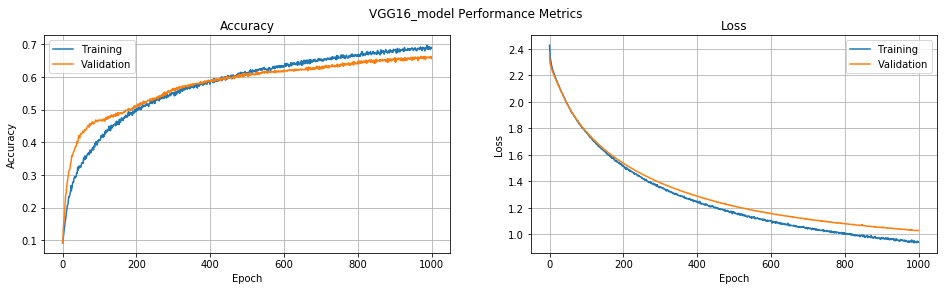

In [32]:
VGG16_model.plot_learning_curves(figures_dir)

#### Pretrained Xception Model :

##### Model Creation :



In [34]:
Xception_model = PretrainedModel("Xception_model",
                             applications.Xception(include_top=False, weights='imagenet',pooling='avg'),
                             data_processor,
                             models_dir)

##### Model Training :


In [52]:
Xception_model.predict_bottleneck_features()

1518/1518 [==============================] - 25s 17ms/step


In [35]:
Xception_model.load_bottleneck_features()

In [36]:
Xception_model.create_top_model(optimizers.SGD(lr=0.01, clipnorm=1.,momentum=0.7))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 256)               524544    
_________________________________________________________________
dense_12 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                1290      
Total params: 558,730
Trainable params: 558,730
Non-trainable params: 0
_________________________________________________________________


In [40]:
# Save top-model architecture to file
Xception_model.save_top_model_graph(figures_dir)

In [57]:
Xception_model.train_top_model(epochs=1000, batch_size=4096)

Epoch 965/1000
7082/7082 [==============================] - 0s 9us/step - loss: 0.2172 - acc: 0.9360 - val_loss: 0.5723 - val_acc: 0.8285
Epoch 966/1000
7082/7082 [==============================] - 0s 9us/step - loss: 0.2177 - acc: 0.9389 - val_loss: 0.5722 - val_acc: 0.8278
Epoch 967/1000
7082/7082 [==============================] - 0s 9us/step - loss: 0.2177 - acc: 0.9376 - val_loss: 0.5726 - val_acc: 0.8259
Epoch 968/1000
7082/7082 [==============================] - 0s 9us/step - loss: 0.2146 - acc: 0.9391 - val_loss: 0.5731 - val_acc: 0.8252
Epoch 969/1000
7082/7082 [==============================] - 0s 10us/step - loss: 0.2225 - acc: 0.9350 - val_loss: 0.5731 - val_acc: 0.8272
Epoch 970/1000
7082/7082 [==============================] - 0s 9us/step - loss: 0.2193 - acc: 0.9360 - val_loss: 0.5731 - val_acc: 0.8265
Epoch 971/1000
7082/7082 [==============================] - 0s 9us/step - loss: 0.2169 - acc: 0.9397 - val_loss: 0.5732 - val_acc: 0.8252
Epoch 972/1000
7082/7082 [=======

In [ ]:
Xception_model.save_top_model_history()

In [37]:
Xception_model.load_top_model_history()

In [0]:
 Xception_model.load_top_model_weights()

##### Model Testing :

In [60]:
[test_loss, test_accuracy] = Xception_model.test_top_model()

1518/1518 [==============================] - 0s 60us/step
[0.5337034053953269, 0.839262186931213]


In [61]:
test_GAP = Xception_model.get_GAP()

0.8150106851119865


In [0]:
stats_csv.add_stats("Xception Model", test_loss, test_accuracy, test_GAP)

##### Model Visualization :

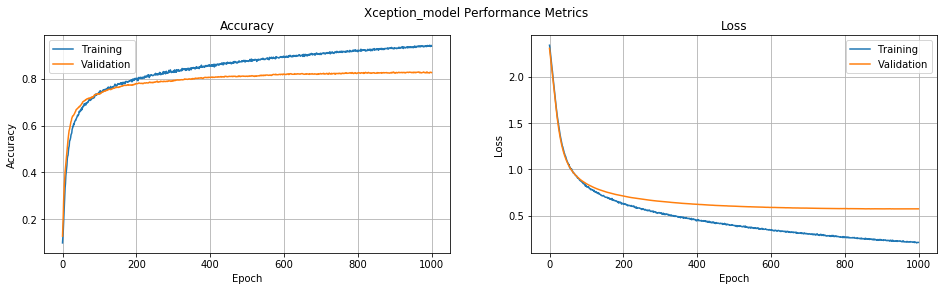

In [38]:
Xception_model.plot_learning_curves(figures_dir)

### Refinement

#### Pretrained VGG16 Model (Refinement) :

##### Model Creation :



In [39]:
VGG16_model_refinement = PretrainedModel("VGG16_model_refinement",
                             applications.VGG16(include_top=False, weights='imagenet',pooling='avg'),
                             data_processor,
                             models_dir)

##### Model Training :


In [65]:
VGG16_model_refinement.predict_bottleneck_features()

1518/1518 [==============================] - 19s 13ms/step


In [40]:
VGG16_model_refinement.load_bottleneck_features()

In [41]:
VGG16_model_refinement.create_top_model(optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_15 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)                1290      
Total params: 165,514
Trainable params: 165,514
Non-trainable params: 0
_________________________________________________________________


In [68]:
VGG16_model_refinement.train_top_model(epochs=1000, batch_size=4096)

Epoch 650/1000
7082/7082 [==============================] - 0s 4us/step - loss: 0.4343 - acc: 0.8448 - val_loss: 0.8874 - val_acc: 0.7210
Epoch 651/1000
7082/7082 [==============================] - 0s 3us/step - loss: 0.3705 - acc: 0.8707 - val_loss: 0.8456 - val_acc: 0.7381
Epoch 652/1000
7082/7082 [==============================] - 0s 3us/step - loss: 0.3462 - acc: 0.8812 - val_loss: 0.8936 - val_acc: 0.7216
Epoch 653/1000
7082/7082 [==============================] - 0s 3us/step - loss: 0.3747 - acc: 0.8700 - val_loss: 0.8987 - val_acc: 0.7236
Epoch 654/1000
7082/7082 [==============================] - 0s 4us/step - loss: 0.3826 - acc: 0.8622 - val_loss: 0.8716 - val_acc: 0.7309
Epoch 655/1000
7082/7082 [==============================] - 0s 3us/step - loss: 0.3605 - acc: 0.8718 - val_loss: 0.8574 - val_acc: 0.7375
Epoch 656/1000
7082/7082 [==============================] - 0s 3us/step - loss: 0.3456 - acc: 0.8815 - val_loss: 0.8634 - val_acc: 0.7355
Epoch 657/1000
7082/7082 [========

In [ ]:
VGG16_model_refinement.save_top_model_history()

In [42]:
VGG16_model_refinement.load_top_model_history()

In [0]:
 VGG16_model_refinement.load_top_model_weights()

##### Model Testing :

In [72]:
[test_loss, test_accuracy] = VGG16_model_refinement.test_top_model()

1518/1518 [==============================] - 0s 65us/step
[0.7469997773135918, 0.7733860340200079]


In [73]:
test_GAP = VGG16_model_refinement.get_GAP()

0.7329643747589238


In [0]:
stats_csv.add_stats("VGG16 Model(Refined)", test_loss, test_accuracy, test_GAP)

##### Model Visualization :

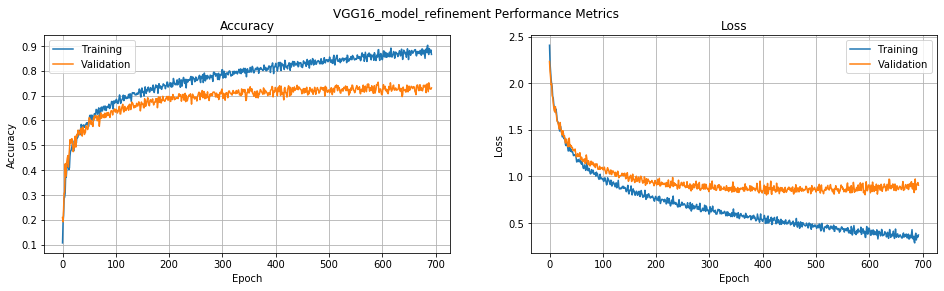

In [43]:
VGG16_model_refinement.plot_learning_curves(figures_dir)

#### Pretrained Xception Model (Refinement):

##### Model Creation :



In [44]:
Xception_model_refinement = PretrainedModel("Xception_model_refinement",
                             applications.Xception(include_top=False, weights='imagenet',pooling='avg'),
                             data_processor,
                             models_dir)

##### Model Training :


In [77]:
Xception_model_refinement.predict_bottleneck_features()

1518/1518 [==============================] - 26s 17ms/step


In [45]:
Xception_model_refinement.load_bottleneck_features()

In [46]:
Xception_model_refinement.create_top_model(optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 256)               524544    
_________________________________________________________________
dense_18 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 10)                1290      
Total params: 558,730
Trainable params: 558,730
Non-trainable params: 0
_________________________________________________________________


In [79]:
Xception_model_refinement.train_top_model(epochs=1000, batch_size=4096)

Epoch 248/1000
7082/7082 [==============================] - 0s 10us/step - loss: 0.1048 - acc: 0.9633 - val_loss: 1.5209 - val_acc: 0.7177
Epoch 249/1000
7082/7082 [==============================] - 0s 10us/step - loss: 0.6212 - acc: 0.8581 - val_loss: 1.0347 - val_acc: 0.7619
Epoch 250/1000
7082/7082 [==============================] - 0s 11us/step - loss: 0.1703 - acc: 0.9374 - val_loss: 0.7527 - val_acc: 0.8272
Epoch 251/1000
7082/7082 [==============================] - 0s 10us/step - loss: 0.0565 - acc: 0.9876 - val_loss: 0.6404 - val_acc: 0.8437
Epoch 252/1000
7082/7082 [==============================] - 0s 10us/step - loss: 0.0249 - acc: 0.9973 - val_loss: 0.6543 - val_acc: 0.8443
Epoch 253/1000
7082/7082 [==============================] - 0s 10us/step - loss: 0.0206 - acc: 0.9976 - val_loss: 0.6707 - val_acc: 0.8450
Epoch 254/1000
7082/7082 [==============================] - 0s 9us/step - loss: 0.0181 - acc: 0.9982 - val_loss: 0.6836 - val_acc: 0.8450
Epoch 255/1000
7082/7082 [==

In [ ]:
Xception_model_refinement.save_top_model_history()

In [47]:
Xception_model_refinement.load_top_model_history()

In [0]:
 Xception_model_refinement.load_top_model_weights()

##### Model Testing :

In [82]:
[test_loss, test_accuracy] = Xception_model_refinement.test_top_model()

1518/1518 [==============================] - 0s 67us/step
[0.5863029530397046, 0.8491436098561143]


In [83]:
test_GAP = Xception_model_refinement.get_GAP()

0.8267506001621842


In [0]:
stats_csv.add_stats("Xception Model(Refined)", test_loss, test_accuracy, test_GAP)

##### Model Visualization :

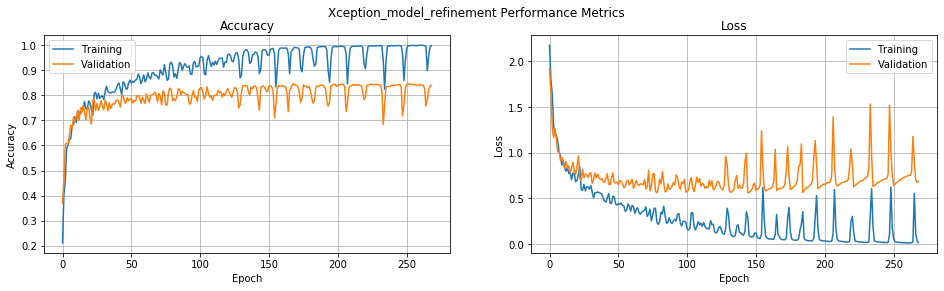

In [48]:
Xception_model_refinement.plot_learning_curves(figures_dir)

## IV. Results

### Model Evaluation and Validation

##### Data Preprocessing

Trying different image input shape 150x150

In [0]:
evaluation_input_shape = (150, 150, 3)

In [87]:
evaluation_data_processor = DataProcessor(
    evaluation_input_shape, 
    batch_size, 
    train_dir, 
    validation_dir,
    test_dir)

Found 7082 images belonging to 10 classes.
Found 1516 images belonging to 10 classes.
Found 1518 images belonging to 10 classes.


##### Model Creation :



In [0]:
evaluation_model = PretrainedModel("evaluation_model",
                             applications.Xception(include_top=False, weights='imagenet',pooling='avg'),
                             evaluation_data_processor,
                             models_dir)

##### Model Training :


In [89]:
evaluation_model.predict_bottleneck_features()

1518/1518 [==============================] - 22s 14ms/step


In [0]:
evaluation_model.load_bottleneck_features()

In [90]:
evaluation_model.create_top_model(optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0))

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 256)               524544    
_________________________________________________________________
dense_32 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 10)                1290      
Total params: 558,730
Trainable params: 558,730
Non-trainable params: 0
_________________________________________________________________


In [91]:
evaluation_model.train_top_model(epochs=1000, batch_size=4096)

Epoch 240/1000
7082/7082 [==============================] - 0s 10us/step - loss: 0.0158 - acc: 0.9992 - val_loss: 1.0012 - val_acc: 0.7817
Epoch 241/1000
7082/7082 [==============================] - 0s 10us/step - loss: 0.0161 - acc: 0.9993 - val_loss: 1.0117 - val_acc: 0.7836
Epoch 242/1000
7082/7082 [==============================] - 0s 9us/step - loss: 0.0149 - acc: 0.9989 - val_loss: 1.0397 - val_acc: 0.7843
Epoch 243/1000
7082/7082 [==============================] - 0s 9us/step - loss: 0.0143 - acc: 0.9987 - val_loss: 1.0399 - val_acc: 0.7856
Epoch 244/1000
7082/7082 [==============================] - 0s 9us/step - loss: 0.0148 - acc: 0.9987 - val_loss: 1.0555 - val_acc: 0.7830
Epoch 245/1000
7082/7082 [==============================] - 0s 11us/step - loss: 0.0143 - acc: 0.9983 - val_loss: 1.0668 - val_acc: 0.7790
Epoch 246/1000
7082/7082 [==============================] - 0s 9us/step - loss: 0.0141 - acc: 0.9996 - val_loss: 1.0771 - val_acc: 0.7823
Epoch 247/1000
7082/7082 [=====

In [0]:
evaluation_model.save_top_model_history()
#evaluation_model.load_top_model_history()

In [0]:
 evaluation_model.load_top_model_weights()

##### Model Testing :

In [94]:
[test_loss, test_accuracy] = evaluation_model.test_top_model()

1518/1518 [==============================] - 0s 80us/step
[0.8985504357239945, 0.7793148879320096]


In [95]:
test_GAP = evaluation_model.get_GAP()

0.7417914545384348


In [0]:
#stats_csv.add_stats("Solution Model Validation", test_loss, test_accuracy, test_GAP)

##### Model Visualization :

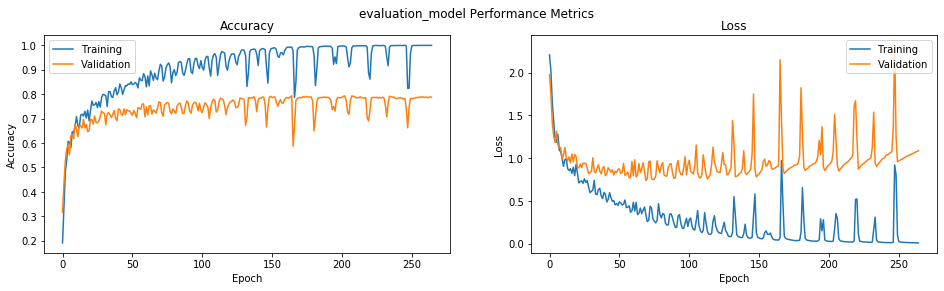

In [97]:
evaluation_model.plot_learning_curves(figures_dir)

### Justification

The final solution model has 84.91% test accuracy score and 82.68% GAP score. Its performance is significantly higher than the benchmark model which had 62.29% test accuracy score and 55.85% GAP score.

## V. Conclusion

### Free-Form Visualization

#### Visualization of predicting images using solution model :

In [0]:
from tqdm import tqdm
from sklearn.datasets import load_files

In [0]:
def extract_VGG16(VGG16model, tensor):
	from keras.applications.vgg16 import VGG16, preprocess_input
	return VGG16model.predict(preprocess_input(tensor))

In [0]:
def extract_Xception(Xceptionmodel, tensor):
	from keras.applications.xception import Xception, preprocess_input
	return Xceptionmodel.predict(preprocess_input(tensor))

Here we assign our best solution model to the variable `solution_model` and preprocessor function to `extract_bottleneck_features` variable

In [0]:
solution_model = Xception_model_refinement

In [0]:
extract_bottleneck_features = extract_Xception

-----------

In [0]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [0]:
# Loading test image paths
test_data = load_files(test_images_dir)
test_images_paths = np.array(test_data['filenames'])

In [107]:
# Getting prediciton labels using solution model :
bottleneck_features = extract_bottleneck_features(solution_model.pretrained_model, paths_to_tensor(test_images_paths))
predicted_classes = solution_model.top_model.predict_classes(bottleneck_features)
predicted_labels = np.array(landmarks_list)[predicted_classes]


100%|██████████| 3/3 [00:00<00:00, 49.95it/s]

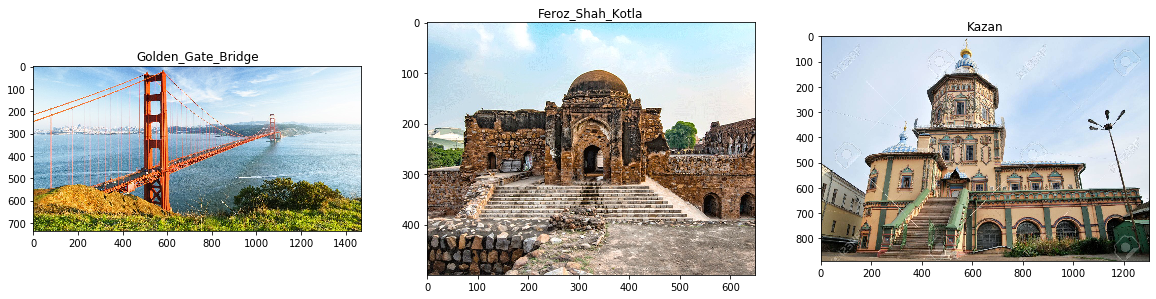

In [109]:
# Plot test images and their predicted labels :
columns = len(predicted_labels)
rows = 1
fig = plt.figure(figsize=(20,20))
for i, image_path in enumerate(test_images_paths):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(load_img(image_path))
    plt.title(predicted_labels[i])
plt.savefig(path.join(figures_dir, "visualization_predicted_images.pdf"), bbox_inches = 'tight')
plt.show()

#### Visualization of similar images from training dataset

In [0]:
def get_train_image_path(image_id, label):
  return path.join(data_dir, 'train', label,  image_id + '.jpg')

In [0]:
similar_train_landmarks_ids =['Kazan','Feroz_Shah_Kotla', 'Golden_Gate_Bridge']

In [0]:
similar_train_images_ids = np.array([
                                    ['3e222ad7d1469deb', '33e8a9c8e96f20eb', '1586d22396244714'],
                                    ['1e33638e9fb39b0d', '2f7b8d029e1402b4', '1e4569e97ea7ade0'],
                                    ['5cd678ac220edb5a', '8c188787c993afba', '8e471206a5892d58'],
                                    ])

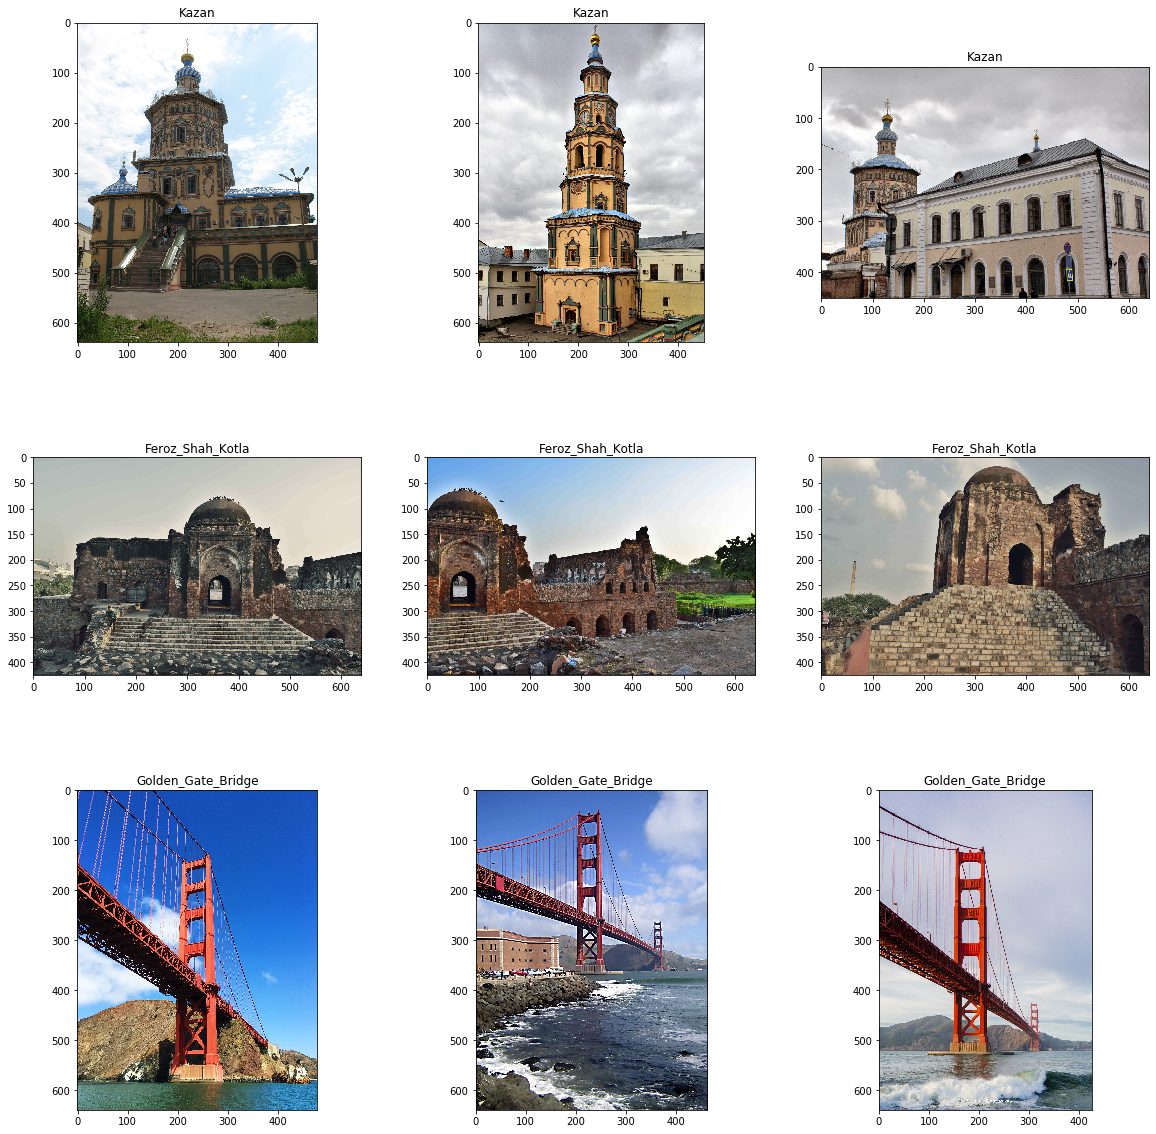

In [113]:
rows = similar_train_images_ids.shape[0]
columns = similar_train_images_ids.shape[1]
fig = plt.figure(figsize=(20,20))

for i, landmark in enumerate(similar_train_images_ids):
  for j, image in enumerate(landmark):
      image_path = get_train_image_path(str(image), str(similar_train_landmarks_ids[i]))
      fig.add_subplot(rows, columns, columns*i + j + 1)
      plt.imshow(load_img(image_path))
      plt.title(similar_train_landmarks_ids[i])

plt.savefig(path.join(figures_dir, "visualization_training_samples.pdf"), bbox_inches = 'tight')
plt.show()

### Reflection

The entire end-to-end problem solution can be summarized as the following :  

1. A challenge problem and an available public dataset were found.
2. A suitable metric was found and implemented.
3. The data was downloaded and split into training, validation and testing sets.
4. The data was prepared and preprocessed to be used as input for the classification model.
5. A simple convolutional neural network benchmark model was implemented and tested.
6. Transfer-learning solution models VGG16 and Xception were implemented, refined and tested. The extraction of bottleneck features was done for each model. Then, a solution model was selected based on performance metrics.
7. Sensitivity analysis was conducted on the solution model using a different resolution of input images.
8. The solution model classifier was tested on unseen images downloaded randomly from the web.  

An interesting aspect of this project was that transfer-learning models achieved great performance in
short training time. Their performance was better than the benchmark model that took a much longer
time to train.  

The challenging aspect of the project was the selection of classes and the extraction of a balanced
subset dataset for the project from the large publicly available dataset. Another challenge was the
implementation of the GAP performance metric and obtaining the correct input vectors.  

Convolutional neural networks in general and transfer-learning techniques, in particular, are the best
for image classification problems (up to current date) as we have seen in this project implementation.
They are highly recommended for such problems and similar problems.

### Improvement

For the improvement of our solution model, my suggestions are the following :
1. Allowing the model to train for longer times on more powerful hardware with capable GPUs. That would speed up experimenting with and testing different solution models in shorter times.
2. Another possible improvement is collecting a larger dataset of landmarks, training the model on a larger count of images and augmenting the available data to increase the count of images per each class.
3. In this project, we froze the original pre-trained networks’ weights and focused on training the top-model that we created (which took bottleneck features as input). We can try fine-tuning each of the original pre-trained models’ weights to achieve a better feature extraction from the input.
4. Proper classification of non-landmark images and the ability to recognize them should be imple- mented.

### Copying output data from colab virtual machine to google drive :

In [114]:
cd /

/


In [115]:
%%shell
tar cvzf stats.tar.gz docs/
tar cvzf models.tar.gz models/
cp -v stats.tar.gz /gdrive/My\ Drive/shared/Udacity_MLND_capstone_dataset/
cp -v models.tar.gz /gdrive/My\ Drive/shared/Udacity_MLND_capstone_dataset/

docs/
docs/stats/
docs/stats/train_freqs.csv
docs/stats/validation_freqs.csv
docs/stats/selected_landmarks.csv
docs/stats/stats.csv
docs/stats/test_freqs.csv
docs/img/
docs/img/Xception_model_refinement_metrics.pdf
docs/img/benchmark_model_metrics.pdf
docs/img/augmented_image_transformations.pdf
docs/img/VGG16_model_refinement_metrics.pdf
docs/img/VGG16_model_metrics.pdf
docs/img/augmented_image_original.pdf
docs/img/evaluation_model_metrics.pdf
docs/img/visualization_predicted_images.pdf
docs/img/dataset_hbar_plot.pdf
docs/img/Xception_model_metrics.pdf
docs/img/visualization_training_samples.pdf
models/
models/VGG16_model_top-model_history.pickle
models/Xception_model_bottleneck_features_train.npz
models/VGG16_model_refinement_bottleneck_features_train.npz
models/VGG16_model_bottleneck_features_validation.npz
models/VGG16_model_bottleneck_features_test.npz
models/Xception_model_refinement_bottleneck_features_train.npz
models/Xception_model_top-model_history.pickle
models/VGG16_model_